In [44]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from env import get_db_url

In [45]:
#Write some SQL - expect 2152863 rows
sql = """
SELECT bedroomcnt as bed,
    bathroomcnt as bath, 
    calculatedfinishedsquarefeet as sf, 
    taxvaluedollarcnt as value, 
    yearbuilt, 
    taxamount, 
    fips
FROM properties_2017
    JOIN propertylandusetype USING(propertylandusetypeid)
WHERE propertylandusedesc = 'Single Family Residential';
"""


In [46]:
df = df_backup = pd.read_sql(sql,get_db_url('zillow'))

In [47]:
df.shape #rows match

(2152863, 7)

In [48]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   bed        2152852 non-null  float64
 1   bath       2152852 non-null  float64
 2   sf         2144379 non-null  float64
 3   value      2152370 non-null  float64
 4   yearbuilt  2143526 non-null  float64
 5   taxamount  2148421 non-null  float64
 6   fips       2152863 non-null  float64
dtypes: float64(7)
memory usage: 115.0 MB


### Investigating the nulls

First, let's look at the nulls of our target variable

In [49]:
df[df.value.isna()].shape

(493, 7)

Only 500 of 2 million, plus we don't want to be imputing our target. 

**ACTION:** Drop all rows where target variable is null

In [50]:
value_null_ind =  df[df.value.isna()].index
df.drop(index=value_null_ind,inplace=True)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152370 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   bed        2152359 non-null  float64
 1   bath       2152359 non-null  float64
 2   sf         2144264 non-null  float64
 3   value      2152370 non-null  float64
 4   yearbuilt  2143408 non-null  float64
 5   taxamount  2148390 non-null  float64
 6   fips       2152370 non-null  float64
dtypes: float64(7)
memory usage: 131.4 MB


Based on the above table, we have fips for every row which makes sense as every parcelid (pk from orginial table) should have a fips.  

The next highest non-null columns are bed and bath.  so let's investigate those first

In [51]:
df[df.bed.isna()]

,bed,bath,sf,value,yearbuilt,taxamount,fips
107763,NaN,NaN,NaN,67366.0,1926.0,780.54,6059.0
118612,NaN,NaN,NaN,43992.0,1946.0,541.64,6059.0
193993,NaN,NaN,1348.0,840698.0,1952.0,NaN,6059.0
1141339,NaN,NaN,200.0,188972.0,NaN,NaN,6037.0
1324608,NaN,NaN,990.0,435000.0,1906.0,NaN,6037.0
1442975,NaN,NaN,NaN,273196.0,NaN,NaN,6037.0
1647346,NaN,NaN,400.0,28347.0,1954.0,NaN,6037.0
1701026,NaN,NaN,NaN,407930.0,1926.0,NaN,6037.0
1722707,NaN,NaN,NaN,477161.0,NaN,NaN,6037.0
1776422,NaN,NaN,NaN,38855.0,NaN,NaN,6037.0


Looking at the above table, this subset of rows have minimal information.  If there is no bed or bath AND half of the remaining columns don't exist, we should just drop.

**ACTION:** Drop all rows where df.bed is null

In [52]:
bed_null_ind = df[df.bed.isna()].index
df.drop(index=bed_null_ind,inplace=True)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152359 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   bed        2152359 non-null  float64
 1   bath       2152359 non-null  float64
 2   sf         2144260 non-null  float64
 3   value      2152359 non-null  float64
 4   yearbuilt  2143401 non-null  float64
 5   taxamount  2148388 non-null  float64
 6   fips       2152359 non-null  float64
dtypes: float64(7)
memory usage: 131.4 MB


Now let's see how many are in the rest of the columns

In [53]:
df[df.sf.isna()].shape

(8099, 7)

In [54]:
df[df.yearbuilt.isna()].shape

(8958, 7)

In [55]:
df[df.taxamount.isna()].shape

(3971, 7)

(array([1347.,    0.,    0.,    0.,    0., 6210.,    0.,    0.,    0.,
        4567.]),
 array([4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8, 6. ]),
 <BarContainer object of 10 artists>)

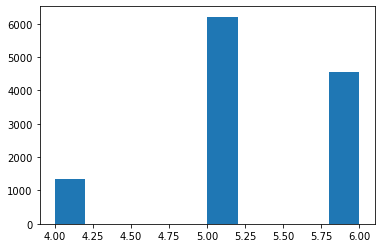

In [56]:
#let's check out some overlap
hist = df.count(axis=1,numeric_only=False)
plt.hist(hist[hist<7])

Looking at the above, a decent number of these are only missing one piece of data.  However, since we are still only looking at ~12k total rows, I am going to go ahead and drop them all.  Ideally, I'd check some of this with stakeholders.  My primary concern is that we may be inadvertently trimming a particular geographic area (perhaps one with poor tax amount reporting to the county)

**ACTION:** Drop all nulls

In [57]:
df.dropna(inplace=True)
df.shape

(2140235, 7)

### Look at the distributions of each feature

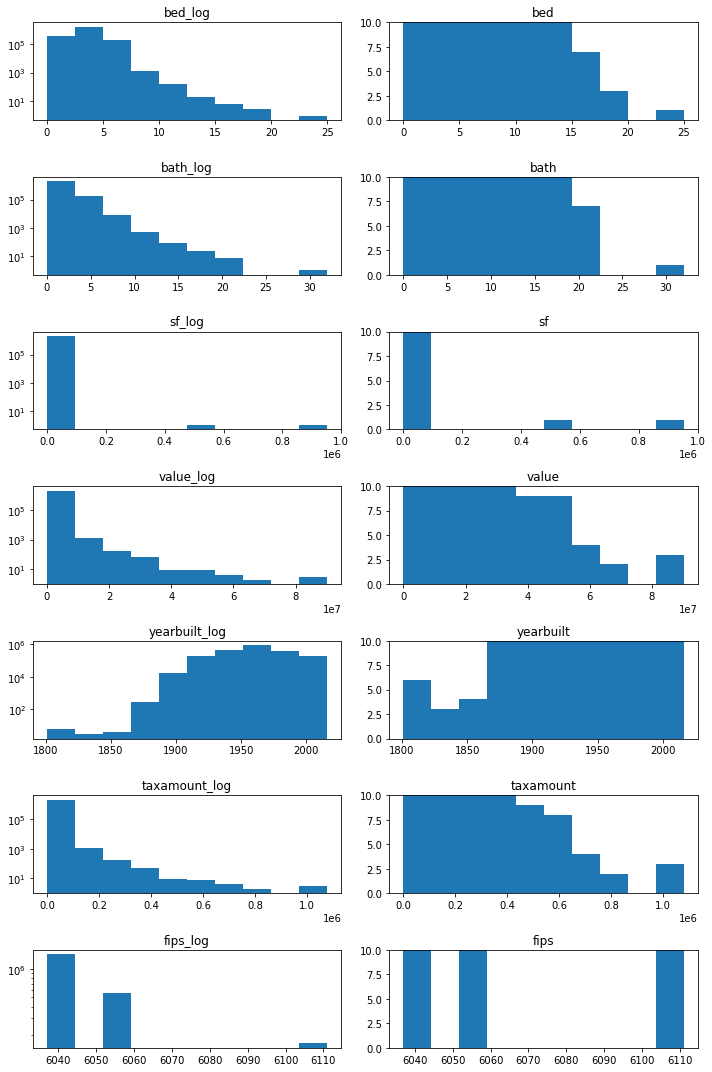

In [58]:
#See on logarythmic scale to better see outliers
plt.figure(figsize=(10,15))
ct=0
for c in df.columns:
    ct +=1
    plt.subplot(7,2,ct)
    plt.hist(df[c])
    plt.title(c+'_log')
    plt.yscale('log')
    ct +=1
    plt.subplot(7,2,ct)
    plt.hist(df[c])
    plt.title(c)
    plt.ylim((0,10))
    
plt.tight_layout()

Definitely some bed, bath, tax, value and year outliers.  I don't want to snap any values in.  I also think it may be best to ignore bed/bath outliers first, then see if addressing sf or value will handle those.

I want to avoid trimming by my target variable, so first I'll trim by sf and hope that it also helps address outliers on the value:
- Since Zillow estimates are not expected to be utilized by the top 1%, I want to cut some of the expensive houses. We'll cut the top .1% of sf homes off the dataset.  NOTE: I recognized that sf is being used as a proxy for value, but it's one method of avoiding trimming by our target so that we can better specify how the model was trained in a useful manner
- Since the data is skewed right, I want to trim less off the left.  After considering a few different cutoffs, I found that california code restricts minimum dwelling size to 120 sq ft. 
  - "Every dwelling unit shall have at least one room that shall have not less than 120 square feet (13.9 m2) of net floor area"
  
**ACTION:** Drop rows with the top .1% of sf or an sf of less than 120

In [59]:
#drop top 1% of sf
df = df[df.sf<df.sf.quantile(.999)]

#drop anything less than 120 sf
df = df[df.sf>=120]
df.shape

(2137960, 7)

In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bed,2137960.0,3.298758,0.926437,0.00,3.0000,3.00,4.0000,18.00
bath,2137960.0,2.234526,0.969255,0.00,2.0000,2.00,3.0000,20.00
sf,2137960.0,1852.191523,902.931396,120.00,1257.0000,1622.00,2206.0000,9407.00
value,2137960.0,452988.461246,580011.793191,22.00,189003.0000,327925.00,533452.0000,49386312.00
yearbuilt,2137960.0,1960.937955,22.127124,1801.00,1949.0000,1958.00,1975.0000,2016.00
taxamount,2137960.0,5528.332096,6666.829586,6.34,2539.4575,4108.38,6402.0425,560290.15
fips,2137960.0,6048.313200,20.348094,6037.00,6037.0000,6037.00,6059.0000,6111.00


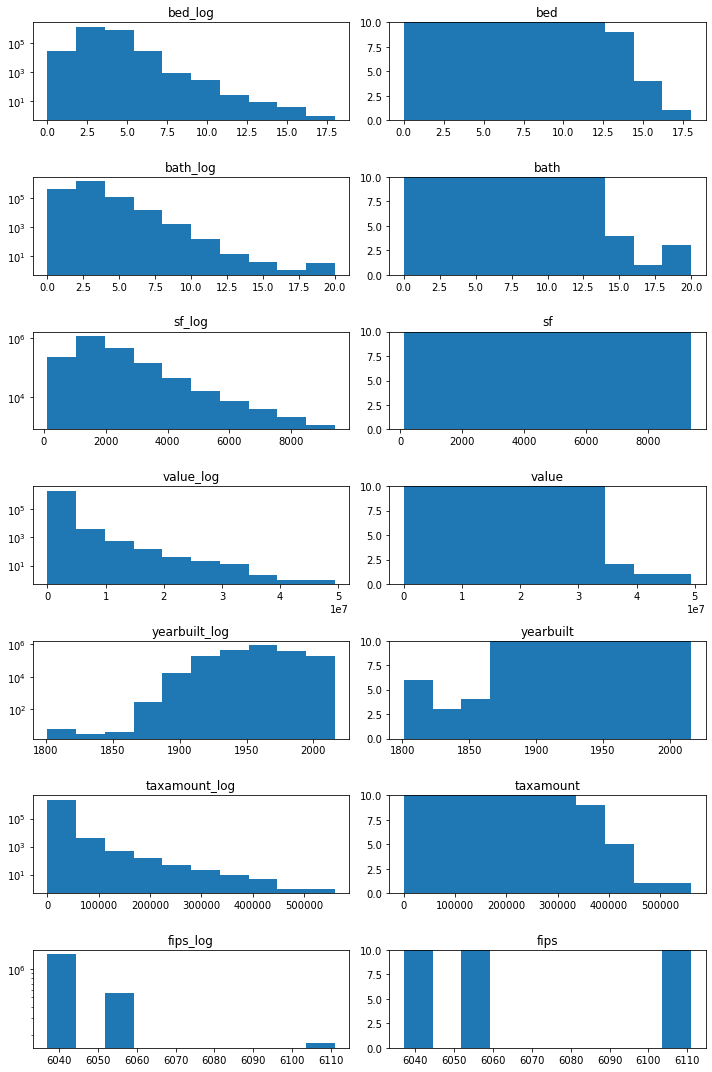

In [61]:
#See on logarythmic scale to better see outliers
plt.figure(figsize=(10,15))
ct=0
for c in df.columns:
    ct +=1
    plt.subplot(7,2,ct)
    plt.hist(df[c])
    plt.title(c+'_log')
    plt.yscale('log')
    ct +=1
    plt.subplot(7,2,ct)
    plt.hist(df[c])
    plt.title(c)
    plt.ylim((0,10))
    
plt.tight_layout()

Even after using sf trimming, we still have quite a few outliers in each category.  Because of that, I'll do more trimming on the high side.  Since Zillow's target customers aren't the super rich, I feel comfortable trimming 10+ bedrooms, 10+ bathrooms and 10+ million value.  While we wanted to avoid any triming by value, it is import to get rid of these extreme outliers.


In [62]:
df[df.bed > 9].shape

(110, 7)

In [63]:
df[df.bath>9].shape

(193, 7)

In [64]:
df[df.value>10_000_000].shape

(703, 7)

In [65]:
df[(df.value>10_000_000) | (df.bath >9) | (df.bed >10)].shape[0] / df.shape[0]

0.00042517165896462046

Even with the extra trimming, that only accounts for .04% of the data.  

**Action:** Drop all rows with 10+ beds, 10+ baths, or a value of 10+ million.

In [66]:
df = df[(df.value < 10_000_000) & (df.bath < 10) & (df.bed <10)]
df.shape

(2136997, 7)

### Now encode our categorical

In [67]:
df.fips.value_counts()

6037.0    1422719
6059.0     551414
6111.0     162864
Name: fips, dtype: int64

In [68]:
#only categorical is FIPS.  I want to map then encode so that I have common sense 
# names for EDA and easy to read columns for the model

#map to county names
df['county'] = df.fips.map({6037: 'LosAngeles_CA',6059:'Orange_CA',6111:'Ventura_CA'})
#encode into dummy df
d_df = pd.get_dummies(df['county'],drop_first=True)
#concat dummy df to the rest
df = pd.concat([df,d_df],axis=1)

In [69]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136997 entries, 4 to 2152862
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bed         2136997 non-null  float64
 1   bath        2136997 non-null  float64
 2   sf          2136997 non-null  float64
 3   value       2136997 non-null  float64
 4   yearbuilt   2136997 non-null  float64
 5   taxamount   2136997 non-null  float64
 6   fips        2136997 non-null  float64
 7   county      2136997 non-null  object 
 8   Orange_CA   2136997 non-null  uint8  
 9   Ventura_CA  2136997 non-null  uint8  
dtypes: float64(7), object(1), uint8(2)
memory usage: 150.8+ MB


### See if other datatypes are appropriate


In [70]:
df.bed.value_counts() #can be integer

3.0    962776
4.0    633251
2.0    334158
5.0    150004
6.0     24354
1.0     22881
7.0      4294
0.0      4245
8.0       834
9.0       200
Name: bed, dtype: int64

In [71]:
(df.yearbuilt % 1).value_counts() # can be integer

0.0    2136997
Name: yearbuilt, dtype: int64

Convert those two to integers

In [72]:
df.bed = df.bed.astype(int)
df.yearbuilt = df.yearbuilt.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136997 entries, 4 to 2152862
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bed         int64  
 1   bath        float64
 2   sf          float64
 3   value       float64
 4   yearbuilt   int64  
 5   taxamount   float64
 6   fips        float64
 7   county      object 
 8   Orange_CA   uint8  
 9   Ventura_CA  uint8  
dtypes: float64(5), int64(2), object(1), uint8(2)
memory usage: 150.8+ MB


### Drop any unecessary columns

taxamount is proportional to tax value.  In addition, tax amount follows tax value.  Major changes in tax amount often come after the sale of a home.  So for Zillow's purposes, we don't want this as a predictor.

In [73]:
#Get rid of original fips column
df.drop(columns=['fips','taxamount'],inplace=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136997 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bed         int64  
 1   bath        float64
 2   sf          float64
 3   value       float64
 4   yearbuilt   int64  
 5   county      object 
 6   Orange_CA   uint8  
 7   Ventura_CA  uint8  
dtypes: float64(3), int64(2), object(1), uint8(2)
memory usage: 118.2+ MB


### Now reorder columns for easier EDA/model splits

In [77]:
df.columns

Index(['bed', 'bath', 'sf', 'value', 'yearbuilt', 'county', 'Orange_CA',
       'Ventura_CA'],
      dtype='object')

In [37]:
df = df.reindex(columns=['value', 'county', 'bed', 'bath', 'sf', 'yearbuilt', 'Orange_CA', 'Ventura_CA'])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136997 entries, 4 to 2152862
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   value       float64
 1   county      object 
 2   bed         int64  
 3   bath        float64
 4   sf          float64
 5   yearbuilt   int64  
 6   taxamount   float64
 7   Orange_CA   uint8  
 8   Ventura_CA  uint8  
dtypes: float64(4), int64(2), object(1), uint8(2)
memory usage: 134.5+ MB


### Dropped work into function in wrangle.py

### Now test the functions

In [39]:
import wrangle

In [40]:
test_df = wrangle.getZillowData()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [41]:
test_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   bed        2152852 non-null  float64
 1   bath       2152852 non-null  float64
 2   sf         2144379 non-null  float64
 3   value      2152370 non-null  float64
 4   yearbuilt  2143526 non-null  float64
 5   taxamount  2148421 non-null  float64
 6   fips       2152863 non-null  float64
dtypes: float64(7)
memory usage: 131.4 MB


In [42]:
tr, te, val = wrangle.prep_zillow(test_df)

In [43]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1495897 entries, 1379475 to 1124006
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   value       1495897 non-null  float64
 1   county      1495897 non-null  object 
 2   bed         1495897 non-null  int64  
 3   bath        1495897 non-null  float64
 4   sf          1495897 non-null  float64
 5   yearbuilt   1495897 non-null  int64  
 6   taxamount   1495897 non-null  float64
 7   Orange_CA   1495897 non-null  uint8  
 8   Ventura_CA  1495897 non-null  uint8  
dtypes: float64(4), int64(2), object(1), uint8(2)
memory usage: 94.2+ MB
